# 00_temp_data_exploration

This notebook __explores temperature data__ for Monterrey in order to find interesting facts and relations __for further analysis and dissemination.__

## Import libraries

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/observatorio/Documents/repos/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Correlation calc
import scipy.stats as stats

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [3]:
city = 'Guadalajara'
res = 8

## Load data

### __Load data__ - Temperature

In [4]:
temp_schema = 'raster_analysis'
temp_table = 'temperature_analysis_hex'

query = f"SELECT * FROM {temp_schema}.{temp_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
temperature_gdf = aup.gdf_from_query(query, geometry_col='geometry')

infs = temperature_gdf.loc[np.isinf(temperature_gdf['temperature_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    temperature_gdf = temperature_gdf.loc[~np.isinf(temperature_gdf['temperature_mean'])].copy()

# Show
print(temperature_gdf.shape)
temperature_gdf.head(2)

(1511, 17)


,hex_id,geometry,res,temperature_mean,temperature_std,temperature_median,temperature_max,temperature_min,temperature_diff,temperature_tend,temperature_2018,temperature_2019,temperature_2020,temperature_2021,temperature_2022,temperature_2023,city
0,88498c9421fffff,"POLYGON ((-103.28663 20.69309, -103.28209 20.6...",8,38.438111,7.315052,38.626435,47.764274,27.717624,20.046651,0.031308,36.122693,39.136411,39.363307,36.741435,38.941005,39.23532,Guadalajara
1,8849aa2d65fffff,"POLYGON ((-103.22891 20.50978, -103.22437 20.5...",8,38.191586,7.621555,37.486231,49.182830,27.666387,21.516443,0.045346,35.142070,39.482854,38.127185,37.602969,38.582998,39.50381,Guadalajara


### __Load data__ - NDVI

In [5]:
ndvi_schema = 'raster_analysis'
ndvi_table = 'ndvi_analysis_hex'

query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

infs = ndvi_gdf.loc[np.isinf(ndvi_gdf['ndvi_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    ndvi_gdf = ndvi_gdf.loc[~np.isinf(ndvi_gdf['ndvi_mean'])].copy()

# Show
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(1513, 17)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city
0,88498c9421fffff,"POLYGON ((-103.28663 20.69309, -103.28209 20.6...",8,0.116626,0.026236,0.126059,0.134537,0.103701,0.030836,-0.000953,0.135403,0.136256,0.136132,0.127048,0.084899,0.080018,Guadalajara
1,8849aa2197fffff,"POLYGON ((-103.33207 20.42909, -103.32754 20.4...",8,0.301783,0.137969,0.258105,0.503622,0.161132,0.342490,-0.001276,0.330410,0.296243,0.358237,0.353359,0.254315,0.218131,Guadalajara


### __Load data__ - Buildings

In [20]:
a="""
# First time (csv to gpkg)

# Read csv
buildings_df = pd.read_csv(str(project_root)+'/data/external/google_open_buildings/843_buildings.csv')
# Convert to gdf
from shapely.wkt import loads
buildings_df["geometry"] = buildings_df["geometry"].apply(loads)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry="geometry", crs="EPSG:4326")

# Save
buildings_gdf.to_file(str(project_root)+"/data/external/google_open_buildings/google_buildings_843.gpkg")
"""

In [22]:
# Read previously created gdf
buildings_gdf = gpd.read_file(str(project_root)+"/data/external/google_open_buildings/google_buildings_843.gpkg")           

# Show
print(buildings_gdf.crs)
print(buildings_gdf.shape)
buildings_gdf.head(2)

EPSG:4326
(17536895, 6)


,latitude,longitude,area_in_meters,confidence,full_plus_code,geometry
0,18.364032,-100.670645,60.4298,0.8018,75CX987H+JP97,"MULTIPOLYGON (((-100.67059 18.36404, -100.6706..."
1,20.446907,-103.526685,10.5973,0.7524,75GRCFWF+Q886,"MULTIPOLYGON (((-103.52667 20.44689, -103.5266..."


## __Analysis 1__ - Tendencia por año

In [7]:
temp_data_years = ['temperature_2018', 'temperature_2019', 'temperature_2020', 'temperature_2021', 'temperature_2022', 'temperature_2023']

temp_stats = temperature_gdf[temp_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
temp_stats.rename(columns={'temperature_2018':'2018',
                           'temperature_2019':'2019',
                           'temperature_2020':'2020',
                           'temperature_2021':'2021',
                           'temperature_2022':'2022',
                           'temperature_2023':'2023'},inplace=True)
temp_stats

,2018,2019,2020,2021,2022,2023
min,23.995591,25.158925,24.870480,24.176172,24.258142,24.379101
mean,34.824012,38.928309,37.669279,36.330798,36.911064,37.685120
median,35.187662,39.012140,38.085915,36.533524,37.351894,38.078815
std,2.459673,2.763451,2.488418,2.351231,2.341727,2.317008
max,40.459971,45.279847,43.937889,41.745694,42.634732,44.447267


In [8]:
temp_stats_transposed = temp_stats.transpose()
temp_stats_transposed.drop(columns=['std'],inplace=True)
temp_stats_transposed

,min,mean,median,max
2018,23.995591,34.824012,35.187662,40.459971
2019,25.158925,38.928309,39.012140,45.279847
2020,24.870480,37.669279,38.085915,43.937889
2021,24.176172,36.330798,36.533524,41.745694
2022,24.258142,36.911064,37.351894,42.634732
2023,24.379101,37.685120,38.078815,44.447267


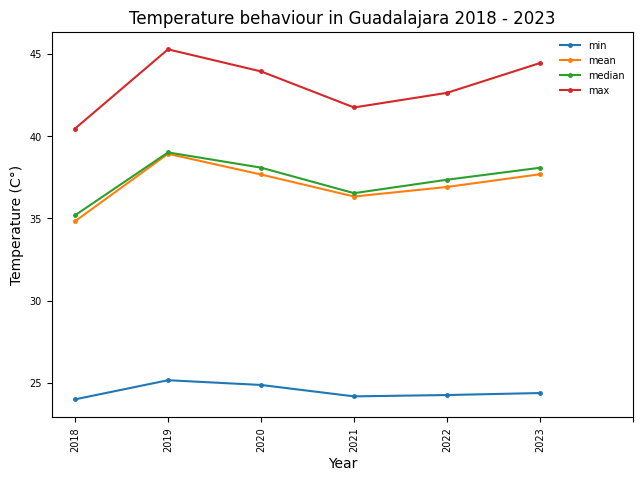

In [9]:
fig, ax = plt.subplots(figsize=(7.5,5))

# ---------- PLOT ----------
temp_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=ax)

# ---------- FORMAT ----------
# Format - Titles
plt.title(f'Temperature behaviour in {city} 2018 - 2023')
plt.xlabel('Year')
plt.ylabel('Temperature (C°)')

# Format - x ticks
# Tag all 6 years
plt.xticks(np.arange(0, 7))
# Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)

# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)

# Format - Legend
plt.legend(frameon=False,
           loc=1, 
           fontsize = 7)

### __Conclusion:__ Needs more data to establish posible tendency, but would be more interesting to see graph by month with overall tendency.

## __Analysis 2__ - Yearly data vs NDVI data

In [10]:
ndvi_data_years = ['ndvi_2018', 'ndvi_2019', 'ndvi_2020', 'ndvi_2021', 'ndvi_2022', 'ndvi_2023']
ndvi_stats = ndvi_gdf[ndvi_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
ndvi_stats.rename(columns={'ndvi_2018':'2018',
                           'ndvi_2019':'2019',
                           'ndvi_2020':'2020',
                           'ndvi_2021':'2021',
                           'ndvi_2022':'2022',
                           'ndvi_2023':'2023'},inplace=True)
ndvi_stats

,2018,2019,2020,2021,2022,2023
min,0.072505,0.071987,0.061923,0.059036,0.037442,0.038348
mean,0.341855,0.291170,0.319444,0.312137,0.209007,0.189164
median,0.353355,0.288632,0.328644,0.326255,0.218183,0.195943
std,0.123424,0.097828,0.112473,0.110608,0.073117,0.063418
max,0.684821,0.616974,0.657586,0.621267,0.432998,0.390246


In [11]:
ndvi_stats_transposed = ndvi_stats.transpose()
ndvi_stats_transposed.drop(columns=['std'],inplace=True)
ndvi_stats_transposed

,min,mean,median,max
2018,0.072505,0.341855,0.353355,0.684821
2019,0.071987,0.291170,0.288632,0.616974
2020,0.061923,0.319444,0.328644,0.657586
2021,0.059036,0.312137,0.326255,0.621267
2022,0.037442,0.209007,0.218183,0.432998
2023,0.038348,0.189164,0.195943,0.390246


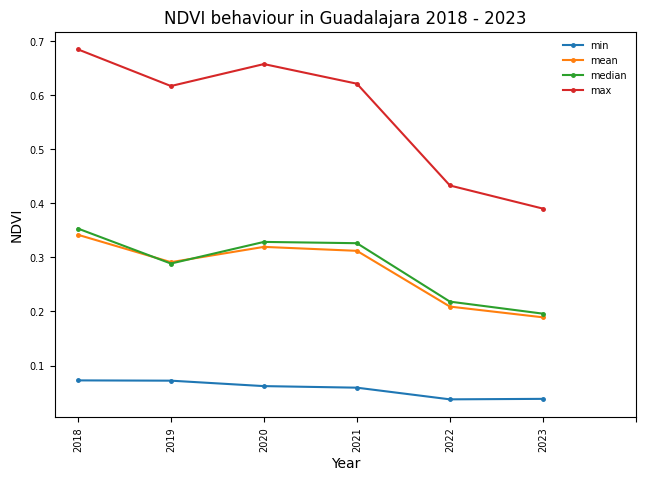

In [12]:
fig, ax = plt.subplots(figsize=(7.5,5))

# ---------- PLOT ----------
ndvi_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=ax)

# ---------- FORMAT ----------
# Format - Titles
plt.title(f'NDVI behaviour in {city} 2018 - 2023')
plt.xlabel('Year')
plt.ylabel('NDVI')

# Format - x ticks
# Tag all 6 years
plt.xticks(np.arange(0, 7))
# Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)

# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)

# Format - Legend
plt.legend(frameon=False,
           loc=1, 
           fontsize = 7)

In [13]:
# Merge temp and ndvi
temperature_ndvi_gdf = pd.merge(temperature_gdf[['hex_id','temperature_mean']],ndvi_gdf[['hex_id','ndvi_mean']],on='hex_id')

# Temperature - Calculate differential between mean in each hex and city mean
mean_city_temperature = temperature_ndvi_gdf.temperature_mean.mean()
print(f"Mean temperature in {city}: {mean_city_temperature}.")
temperature_ndvi_gdf['temperature_diferential'] = temperature_ndvi_gdf['temperature_mean'] - mean_city_temperature

# NDVI - Calculate differential between mean in each hex and city mean
mean_city_ndvi = temperature_ndvi_gdf.ndvi_mean.mean()
print(f"Mean NDVI in {city}: {mean_city_ndvi}.")
temperature_ndvi_gdf['ndvi_diferential'] = temperature_ndvi_gdf['ndvi_mean'] - mean_city_ndvi

# Show
print(temperature_ndvi_gdf.shape)
temperature_ndvi_gdf.head(2)

Mean temperature in Guadalajara: 37.06662650646621.
Mean NDVI in Guadalajara: 0.27711274397000535.
(1511, 5)


,hex_id,temperature_mean,ndvi_mean,temperature_diferential,ndvi_diferential
0,88498c9421fffff,38.438111,0.116626,1.371485,-0.160487
1,8849aa2d65fffff,38.191586,0.243362,1.124960,-0.033751


Text(0, 0.5, "NDVI diferential with city's mean")

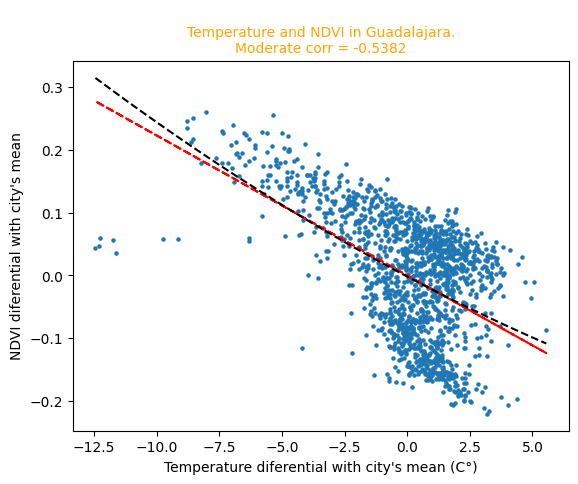

In [14]:
gdf = temperature_ndvi_gdf.copy()
i = 'temperature_diferential'
j = 'ndvi_diferential'

fig,ax = plt.subplots()

# Calculate corr
corr, pval = stats.pearsonr(gdf[i],gdf[j])

# Correlation categories
abs_corr = abs(corr)
if abs_corr > 0.80:
    corr_cat = 'Very strong'
    color='darkgreen'
elif (abs_corr<0.80) and (abs_corr>0.60):
    corr_cat = 'Strong'
    color = 'yellowgreen'
elif (abs_corr<0.60) and (abs_corr>0.40):
    corr_cat = 'Moderate'
    color = 'orange'
else:
    corr_cat = 'Weak/very weak'
    color = 'red'

# Plot scatter
ax.scatter(gdf[i], gdf[j], s=5,zorder=0)

# Linear regresion
m, b = np.polyfit(gdf[i], gdf[j], 1)
ax.plot(gdf[i], m*gdf[i] + b, color="red", linestyle="--", label="Trend line",zorder=1)

# Quadratic regresian
coef = np.polyfit(gdf[i], gdf[j], 2) # a*x^2 + b*x + c coeficients
p = np.poly1d(coef) #Helps create curve
# X and Y values based on previous regresion
x_fit = np.linspace(gdf[i].min(), gdf[i].max(), 100) # Rango de X
y_fit = p(x_fit)
# Plot
ax.plot(x_fit, y_fit, color="black", linestyle="--", label="Quadratic trend",zorder=2)

# ---------- FORMAT ----------
# Format - Main title
plt.title(f"""
Temperature and NDVI in {city}.
{corr_cat} corr = {round(corr, 4)}""",fontsize=10,color=color)

# Format - Axis titles
plt.xlabel("Temperature diferential with city's mean (C°)")
plt.ylabel("NDVI diferential with city's mean")

## __Analysis 3__ - Temperature vs built percentage

In [ ]:
buildings_hex = temperature_gdf[['hex_id','geometry']].sjoin(buildings_gdf)

buildings_hex